Importing dataset via csv

In [1]:
#importing data from drive
from google.colab import files
uploaded = files.upload()

Saving 20221201_trades.csv.gz to 20221201_trades.csv.gz


In [3]:
#reading gz file and converting into csv dataframe:Dont implement it if there is only one csv
## Merge Multiple 1M Rows CSV files
import os
import pandas as pd

# 1. defines path to csv files
path = "/content/"

# 2. creates list with files to merge based on name convention
file  = [path + f for f in os.listdir(path) if f.startswith('2022')]

# 3. creates empty list to include the content of each file converted to pandas DF
csv = []
 
# 4. reads each (sorted) file in file_list, converts it to pandas DF and appends it to the csv
for file in sorted(file):
    csv.append(pd.read_csv(file).assign(File_Name = os.path.basename(file)))

# 5. merges single pandas DFs into a single DF, index is refreshed 
csv_merged = pd.concat(csv, ignore_index=True)

# 6. Single DF is saved to the path in CSV format, without index column
csv_merged.to_csv(path + 'trade_data.csv', index=False)

In [4]:
#reading gz file and converting into csv dataframe
import gc
import pandas as pd
df = pd.read_csv('trade_data.csv') ## reading csv datasets as panda dataframe
df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME']) # coverting collection time to date time type
df = df.set_index('COLLECTION_TIME')#setting collection_time as index
df.head()


MESSAGE_ID MESSAGE_TYPE SYMBOL   PRICE  SIZE  \
COLLECTION_TIME                                                               
2022-12-01 13:02:02.573103104       57914            T   AAPL  147.92    50   
2022-12-01 13:02:02.573189888       57915            T   AAPL  147.92    50   
2022-12-01 13:02:02.573231104       57916            T   AAPL  147.92    50   
2022-12-01 13:02:32.603248896       59439            T   AAPL  147.90    50   
2022-12-01 13:02:54.504649984       60535            T   AAPL  147.95    10   

                               TRADE_ID             TRADE_FLAGS  \
COLLECTION_TIME                                                   
2022-12-01 13:02:02.573103104   3015801  EXTENDED_HOURS|ODD_LOT   
2022-12-01 13:02:02.573189888   3015806  EXTENDED_HOURS|ODD_LOT   
2022-12-01 13:02:02.573231104   3015811  EXTENDED_HOURS|ODD_LOT   
2022-12-01 13:02:32.603248896   3069963  EXTENDED_HOURS|ODD_LOT   
2022-12-01 13:02:54.504649984   3115808  EXTENDED_HOURS|ODD_LOT   

                                            File_Name  
COLLECTION_TIME                                        
2022-12-01 13:02:02.573103104  20221201_trades.csv.gz  
2022-12-01 13:02:02.573189888  20221201_trades.csv.gz  
2022-12-01 13:02:02.573231104  20221201_trades.csv.gz  
2022-12-01 13:02:32.603248896  20221201_trades.csv.gz  
2022-12-01 13:02:54.504649984  20221201_trades.csv.gz

In [36]:
df = df.reset_index()
import plotly.express as px
fig = px.line(df, x="COLLECTION_TIME", y='PRICE', title='Stock Prices History')
fig.show()

Dataset transformation : normalization and splitting data into train and test

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import math 

In [7]:
#Generatng X and y datasets for train and test

X = df.loc[:,('PRICE')]
y = df.loc[:,('PRICE')]

#scaling X and y values to 0 and 1 using scaler
min_scaler = MinMaxScaler()

X_ss = min_scaler.fit_transform(X.values.reshape(-1,1)) # X_ss is scaled version of PRICE
  



Splitting the dataset into train and test using lookback 


In [8]:
def split(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    #print(data.shape)
    #checking the len size
    test_len = math.ceil(len(data)*0.3) # splitting the dataset into 80:20 train and test
    train_len = len(data) - (test_len);
    
    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_test = data[train_len:,:-1]
    y_test = data[train_len:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [9]:
lookback = 60  

#calling the functions in this code
x_train, y_train, x_test, y_test = split(X_ss, lookback)##calling the function 


In [10]:
#checking the shape converting 2d to 3d array : it is for testing purpose 

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7443, 59, 1)
(7443, 1)
(3191, 59, 1)
(3191, 1)


In [11]:
test_len = len(x_test) # splitting the dataset into 80:20 train and test
train_len = len(x_train)


Torch model using pytorch 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable 

In [13]:
#Dimensions of LSTM model
input_dim = 1
hidden_dim = 32
num_layers = 3
output_dim = 1
num_epochs = 300

In [14]:
#Part 2 : LSTM function
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out[:, -1, :]) 
        return out
model = LSTM(input_dim= input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers) #calling this function to define dimensions of lstm 


In [15]:
import numpy as np
import time


# Part 1 : converting to tensor :

x_train_final = torch.from_numpy(x_train).type(torch.Tensor)
x_test_final= torch.from_numpy(x_test).type(torch.Tensor)
y_train_final = torch.from_numpy(y_train).type(torch.Tensor)
y_test_final = torch.from_numpy(y_test).type(torch.Tensor)

#part.2 calling th model LSTM function 

#part3 : training the model 
hist = np.zeros(num_epochs) #creating a varibale
lstm = []
criterion = torch.nn.MSELoss(reduction='mean')# criteria for error
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)# optimzer for tuning the model
for t in range(num_epochs):
    y_train_pred = model(x_train_final)# passing X_train_final dataset into LSTM model(part2)
    loss = criterion(y_train_pred, y_train_final)#compare predicted value vs actual value
    if t%10==0:
      print("Epoch: %d, loss: %1.5f" % (t, loss.item())) # printing the loss
      
    hist[t] = loss.item()# saving the loss
    optimiser.zero_grad()# 
    loss.backward()# backward propogation 
    optimiser.step()# next step

Epoch: 0, loss: 0.29195
Epoch: 10, loss: 0.10720
Epoch: 20, loss: 0.05608
Epoch: 30, loss: 0.03744
Epoch: 40, loss: 0.03578
Epoch: 50, loss: 0.03354
Epoch: 60, loss: 0.02906
Epoch: 70, loss: 0.02050
Epoch: 80, loss: 0.00468
Epoch: 90, loss: 0.00313
Epoch: 100, loss: 0.00262
Epoch: 110, loss: 0.00184
Epoch: 120, loss: 0.00153
Epoch: 130, loss: 0.00135
Epoch: 140, loss: 0.00119
Epoch: 150, loss: 0.00107
Epoch: 160, loss: 0.00098
Epoch: 170, loss: 0.00092
Epoch: 180, loss: 0.00087
Epoch: 190, loss: 0.00082
Epoch: 200, loss: 0.00079
Epoch: 210, loss: 0.00075
Epoch: 220, loss: 0.00072
Epoch: 230, loss: 0.00070
Epoch: 240, loss: 0.00068
Epoch: 250, loss: 0.00066
Epoch: 260, loss: 0.00065
Epoch: 270, loss: 0.00064
Epoch: 280, loss: 0.00063
Epoch: 290, loss: 0.00062


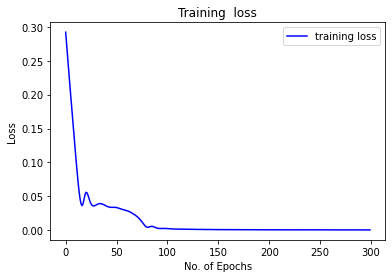

In [16]:
#plotting the losses
import matplotlib.pyplot as plt

plt.plot(hist,'b', label='training loss')
plt.title('Training  loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Part 4 : predicting the price using X_test data and Validation 
predicted_train = np.array([])
out = model(x_test_final) # running for test data and pasing it to LSTM model(part2)
out = out.cpu().detach().numpy()# predicting the values
#final output
predicted_value = min_scaler.inverse_transform(out)# coverting normalised value to standard price 
#rmse
y_actual = min_scaler.inverse_transform(y_test_final)#Conversion of actual value 
rmse = np.sqrt(np.mean(predicted_value  - y_actual)**2) #RMSE
print(rmse)

0.006097737132701348


In [18]:
col_names = ["predicted_price"]
predicted_price = pd.DataFrame(predicted_value, columns = col_names)
col_names2 = ["y_test_predicted"]
out = pd.DataFrame(out,columns = col_names2)


In [19]:
#preparing the validation dataset
df4 = df #d3 signifies the whole dataset ~ train and test
df5 = df4[train_len:] # spliting the df4 dataframe and segregating test data from df4
train = df4[:train_len]['PRICE'] # selecting price for training data

In [20]:
df5 = df5.reset_index()
validation = pd.concat([df5, predicted_price,out],axis=1,sort=False)


In [21]:
validation = validation.dropna()


In [22]:
validation = validation.set_index("COLLECTION_TIME")


In [23]:
validation.tail()

MESSAGE_ID MESSAGE_TYPE SYMBOL   PRICE  SIZE  \
COLLECTION_TIME                                                               
2022-12-01 20:59:49.128360960   122812460            T   AAPL  148.40   262   
2022-12-01 20:59:49.128375040   122812462            T   AAPL  148.40   100   
2022-12-01 20:59:49.128463104   122812463            T   AAPL  148.39   100   
2022-12-01 20:59:49.128464896   122812464            T   AAPL  148.39    80   
2022-12-01 20:59:49.602611968   122823146            T   AAPL  148.43   100   

                                 TRADE_ID  \
COLLECTION_TIME                             
2022-12-01 20:59:49.128360960  3931934332   
2022-12-01 20:59:49.128375040  3931934419   
2022-12-01 20:59:49.128463104  3931934430   
2022-12-01 20:59:49.128464896  3931934445   
2022-12-01 20:59:49.602611968  3932327316   

                                                                     TRADE_FLAGS  \
COLLECTION_TIME                                                                    
2022-12-01 20:59:49.128360960                                      REGULAR_HOURS   
2022-12-01 20:59:49.128375040                    INTERMARKET_SWEEP|REGULAR_HOURS   
2022-12-01 20:59:49.128463104  INTERMARKET_SWEEP|REGULAR_HOURS|TRADE_THROUGH_...   
2022-12-01 20:59:49.128464896  INTERMARKET_SWEEP|REGULAR_HOURS|ODD_LOT|TRADE_...   
2022-12-01 20:59:49.602611968                    INTERMARKET_SWEEP|REGULAR_HOURS   

                                            File_Name  predicted_price  \
COLLECTION_TIME                                                          
2022-12-01 20:59:49.128360960  20221201_trades.csv.gz       148.378815   
2022-12-01 20:59:49.128375040  20221201_trades.csv.gz       148.377396   
2022-12-01 20:59:49.128463104  20221201_trades.csv.gz       148.375977   
2022-12-01 20:59:49.128464896  20221201_trades.csv.gz       148.374420   
2022-12-01 20:59:49.602611968  20221201_trades.csv.gz       148.373047   

                               y_test_predicted  
COLLECTION_TIME                                  
2022-12-01 20:59:49.128360960          0.709199  
2022-12-01 20:59:49.128375040          0.708626  
2022-12-01 20:59:49.128463104          0.708058  
2022-12-01 20:59:49.128464896          0.707428  
2022-12-01 20:59:49.602611968          0.706875

In [24]:
validation.columns

Index(['MESSAGE_ID', 'MESSAGE_TYPE', 'SYMBOL', 'PRICE', 'SIZE', 'TRADE_ID',
       'TRADE_FLAGS', 'File_Name', 'predicted_price', 'y_test_predicted'],
      dtype='object')

In [ ]:
#validation = validation.set_index('COLLECTION_TIME')
train = train.set_index('COLLECTION_TIME')

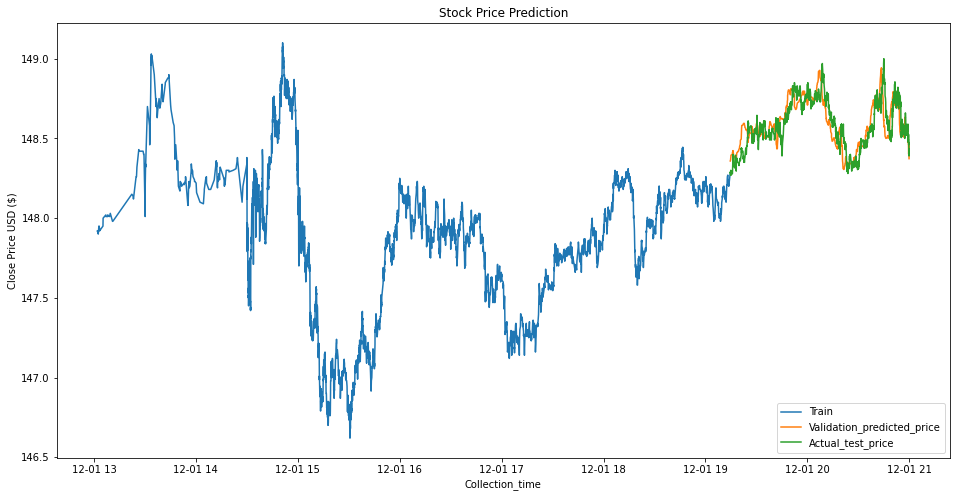

In [81]:

#Plottting the train and test
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.xlabel('Collection_time')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['predicted_price','PRICE']])
plt.legend(['Train', 'Validation_predicted_price', 'Actual_test_price'], loc='lower right')
#plt.gcf().autofmt_xdate() 
plt.show()

Forecasting:
We are trying to predict the stocks prices using historical data.It is an extension of LSTM model.

predict the future stock price using historical data
Impelement the buy and sell strategy

In [26]:
from numpy.core.multiarray import min_scalar_type
# time_gap = 2 sec ; So in 1 min = 30 timesteps; 
look_back = 2400# 1.5 hour
num_prediction = 1000 #predict for 10 mins

def predicted_price(num_prediction):
  prediction_list = X_ss[-look_back:] #creating varibale 
  for i in range(num_prediction):
      x = prediction_list[-look_back:] #looking historical values
      #x1 = min_scaler.fit_transform(x.values.reshape(-1,1))
      x1 = Variable(torch.Tensor(x))#converting  it to tensor
      x1 = torch.reshape(x1,(x1.shape[0],1,x1.shape[1]))# reshaping it to 3d
      train_predict = model(x1) # calling LSTM1 function
      out = train_predict.data.numpy()[0][0] #predict new variables
      #print(prediction_list.shape)
      prediction_list = np.append(prediction_list, out) # adding it to prediction variable
      prediction_list = prediction_list.reshape(-1,1)
  prediction_list = prediction_list[look_back-1:]#shifting one value back
  return prediction_list

forecast_price_feature = predicted_price(num_prediction)
forecast_price_scaled = min_scaler.inverse_transform(forecast_price_feature.reshape(-1,1))# since predicted values are normalised, we convert into predicted value by using inverse function 

In [27]:
validation = validation.reset_index()
validation = validation.dropna()

In [28]:
X= X.reset_index()
#prediciting future time
def predict_time(num_prediction):
    last_date = validation['COLLECTION_TIME'].values[-1]
    predictiontime = pd.date_range(last_date, periods=num_prediction+1,freq = '2S').tolist() #incrementing time by 2 secs
    return predictiontime
forecast_times = predict_time(num_prediction)#calling collection_time

In [29]:
#converting the variables into pandas
forecasted_price = pd.DataFrame(forecast_price_scaled)
forecasted_time = pd.DataFrame(forecast_times)
forecast_price_feature = pd.DataFrame(forecast_price_feature)

In [30]:
#combining dataset of forecasted time and date to create new dataset
forecasted_data = pd.concat([forecasted_time,forecasted_price,forecast_price_feature],axis = "columns")
forecasted_data.columns = ['Forecasted_time','Forecasted_price','forecast_price_feature']
forecasted_data.head()

Forecasted_time  Forecasted_price  forecast_price_feature
0 2022-12-01 20:59:49.602611968        148.330000                0.689516
1 2022-12-01 20:59:51.602611968        146.723025                0.041542
2 2022-12-01 20:59:53.602611968        146.723183                0.041606
3 2022-12-01 20:59:55.602611968        146.723500                0.041734
4 2022-12-01 20:59:57.602611968        146.723500                0.041734

In [31]:
len(forecasted_data)

1001

In [32]:
validation = validation.dropna()

In [33]:
validation.tail()

COLLECTION_TIME  MESSAGE_ID MESSAGE_TYPE SYMBOL   PRICE  \
3186 2022-12-01 20:59:49.128360960   122812460            T   AAPL  148.40   
3187 2022-12-01 20:59:49.128375040   122812462            T   AAPL  148.40   
3188 2022-12-01 20:59:49.128463104   122812463            T   AAPL  148.39   
3189 2022-12-01 20:59:49.128464896   122812464            T   AAPL  148.39   
3190 2022-12-01 20:59:49.602611968   122823146            T   AAPL  148.43   

      SIZE    TRADE_ID                                        TRADE_FLAGS  \
3186   262  3931934332                                      REGULAR_HOURS   
3187   100  3931934419                    INTERMARKET_SWEEP|REGULAR_HOURS   
3188   100  3931934430  INTERMARKET_SWEEP|REGULAR_HOURS|TRADE_THROUGH_...   
3189    80  3931934445  INTERMARKET_SWEEP|REGULAR_HOURS|ODD_LOT|TRADE_...   
3190   100  3932327316                    INTERMARKET_SWEEP|REGULAR_HOURS   

                   File_Name  predicted_price  y_test_predicted  
3186  20221201_trades.csv.gz       148.378815          0.709199  
3187  20221201_trades.csv.gz       148.377396          0.708626  
3188  20221201_trades.csv.gz       148.375977          0.708058  
3189  20221201_trades.csv.gz       148.374420          0.707428  
3190  20221201_trades.csv.gz       148.373047          0.706875

In [34]:
forecasted_data.head()

Forecasted_time  Forecasted_price  forecast_price_feature
0 2022-12-01 20:59:49.602611968        148.330000                0.689516
1 2022-12-01 20:59:51.602611968        146.723025                0.041542
2 2022-12-01 20:59:53.602611968        146.723183                0.041606
3 2022-12-01 20:59:55.602611968        146.723500                0.041734
4 2022-12-01 20:59:57.602611968        146.723500                0.041734

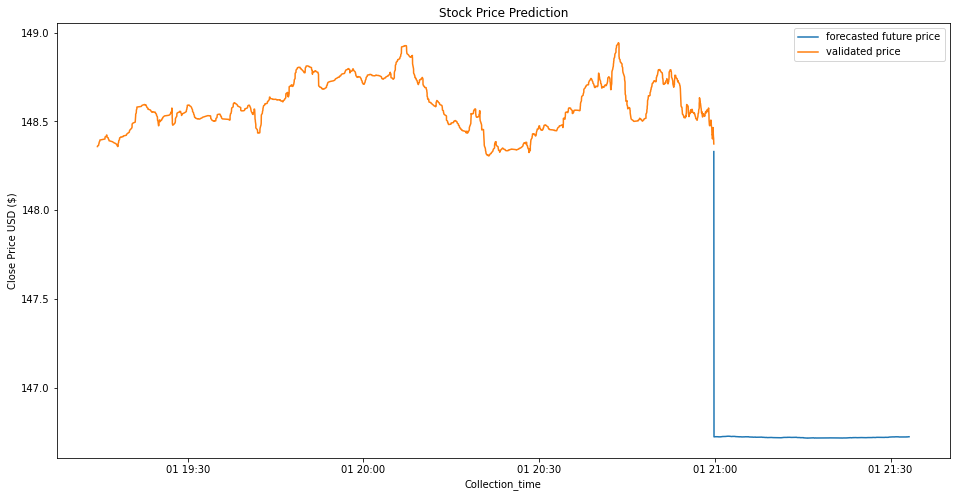

In [89]:
#plot the graph
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.xlabel('Collection_time')
plt.ylabel('Close Price USD ($)')
#validation = validation.set_index('COLLECTION_TIME')
plt.plot(forecasted_data['Forecasted_time'],forecasted_data['Forecasted_price'])
plt.plot(validation['predicted_price'][-3600:])
#plt.plot(train[-500:])
plt.legend(['forecasted future price', 'validated price','train'], loc='upper right')

plt.show()